# **Problem Statement**

## Context

Car crashes are a leading cause of injury and death worldwide, and improving vehicle safety is a critical concern for car manufacturers. With advancements in technology and engineering, manufacturers are continuously seeking ways to design safer vehicles to reduce fatalities and severe injuries in the event of a crash. Despite these efforts, understanding the precise factors that contribute to survival in car crashes remains a complex challenge.

The problem arises from the nature of car accidents, where various elements such as impact speed, the use of safety features, the type of collision, and the demographics of the occupants all play significant roles. Each crash is unique, and even minor variations can significantly affect the outcome for the occupants. This complexity necessitates a detailed analysis to identify which factors are most influential in determining survival outcomes.

Solving this problem is essential for several reasons:

1. Safety Regulations
2. Design Improvements
3. Public Health
4. Consumer Confidence

## Objective


Over the last year, the Department of Road Transport has witnessed a 15% YoY rise in the number of car crashes happening in urban areas. While they have the causes of the accidents post-facto, they want to preempt the risk to increase road safety.

You have been hired as a data scientist and provided with a sample of the historical car crashes over 5 years, with different attributes of the car and the occupant relevant to the car crash. Your objective is to analyze the data, identify patterns in car crashes, build a predictive model to determine the likelihood of survival in car crashes based on the factors and identify the most critical factors that influence survival outcomes, thereby helping the department come up with necessary safety regulations that must be adopted by all vehicle manufacturers and users.

## Data Description

The data contains the different attributes of car crashes, with the outcome variable being whether the occupant was deceased during the crash or not. The detailed data dictionary is given below.

**Data Dictionary**

* caseid: character, created by pasting together the population sampling unit, the case number, and the vehicle number. Within each year, use this to uniquely identify the vehicle.
* speed_range: factor with levels (estimated impact speeds) 1-9 km/h, 10-24 km/h, 25-39 km/h, 40-54 km/h, 55+ km/h
*  weight: Observation weights, albeit of uncertain accuracy, are designed to account for varying sampling probabilities. (The inverse probability weighting estimator can be used to demonstrate causality when the researcher cannot conduct a controlled experiment but has observed data to model)
* seatbelt: a factor with levels none or belted
* frontal_impact: a numeric vector; 0 = non-frontal, 1=frontal impact
* sex: a factor with levels f: Female or m: Male
* age_of_occ: age of occupant in years
* year_of_acc: year of accident
* model_year: Year of model of vehicle; a numeric vector
* airbag: Did one or more (driver or passenger) airbag(s) deploy? This factor has levels deploy, nodeploy, and unavail
* occ_role: a factor with levels driver or pass: passenger
* deceased: the target variable with levels no (survived) or yes (not survived / deceased)


# **Importing the necessary libraries**

In [248]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# setting the precision of floating numbers to 5 decimal points
pd.set_option("display.float_format", lambda x: "%.5f" % x)

# Library to split data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# To build model for prediction
import statsmodels.api as SM
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# To tune different models
from sklearn.model_selection import GridSearchCV

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve
)

import warnings
warnings.filterwarnings("ignore")

# **Loading the dataset**

In [249]:
cars = pd.read_csv('Car_Crash.csv')

In [250]:
# copying data to another variable to avoid any changes to original data
data = cars.copy()

# **Data Overview**

In [251]:
data.head()

,caseid,speed_range,weight,seatbelt,frontal_impact,sex,age_of_occ,year_of_acc,model_year,airbag,occ_role,deceased
0,02:13:02,55+ km/h,27.07800,none,1,m,32,1997,1987,unavail,driver,yes
1,02:17:01,25-39 km/h,89.62700,belted,0,f,54,1997,1994,nodeploy,driver,yes
2,0.138206019,55+ km/h,27.07800,belted,1,m,67,1997,1992,unavail,driver,yes
3,0.138206019,55+ km/h,27.07800,belted,1,f,64,1997,1992,unavail,pass,yes
4,04:58:01,55+ km/h,13.37400,none,1,m,23,1997,1986,unavail,driver,yes


In [252]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11217 entries, 0 to 11216
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   caseid          11217 non-null  object 
 1   speed_range     11217 non-null  object 
 2   weight          11217 non-null  float64
 3   seatbelt        11217 non-null  object 
 4   frontal_impact  11217 non-null  int64  
 5   sex             11217 non-null  object 
 6   age_of_occ      11217 non-null  int64  
 7   year_of_acc     11217 non-null  int64  
 8   model_year      11217 non-null  int64  
 9   airbag          11217 non-null  object 
 10  occ_role        11217 non-null  object 
 11  deceased        11217 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 1.0+ MB


## Data Preprocessing

In [253]:
# checking for duplicate values
data.duplicated().sum()

0

In [254]:
# checking for null values
data.isnull().sum()

caseid            0
speed_range       0
weight            0
seatbelt          0
frontal_impact    0
sex               0
age_of_occ        0
year_of_acc       0
model_year        0
airbag            0
occ_role          0
deceased          0
dtype: int64

* veh_usage_duration: Indicates the time period (in years) the vehicle has been in use

In [255]:
data['year_of_acc'].unique()

array([1997, 1998, 1999, 2000, 2001, 2002], dtype=int64)

In [256]:
data['veh_usage_duration'] = data['year_of_acc'] - data['model_year']

# **Exploratory Data Analysis (EDA)**

**The below functions need to be defined to carry out the EDA.**

In [257]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [258]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        hue=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [259]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [260]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

## Univariate Analysis

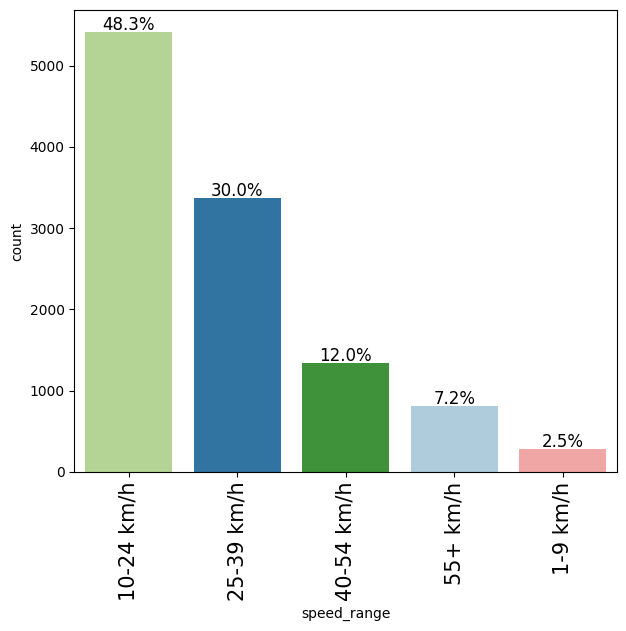

In [261]:
labeled_barplot(data, "speed_range", perc=True)  ##Complete the code to get the labeled_barplot for speed_range

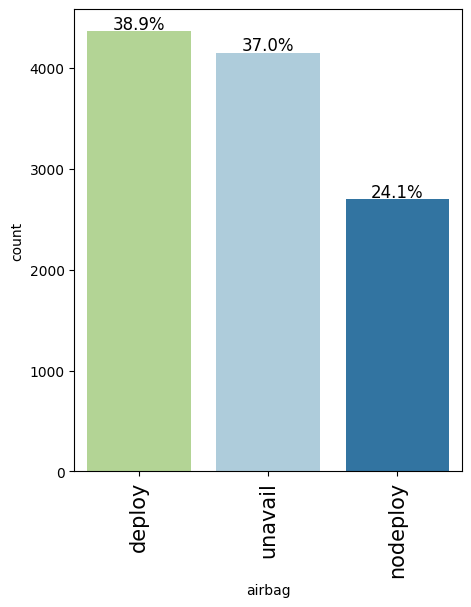

In [262]:
labeled_barplot(data, "airbag", perc=True)  ##Complete the code to get the labeled_barplot for airbag

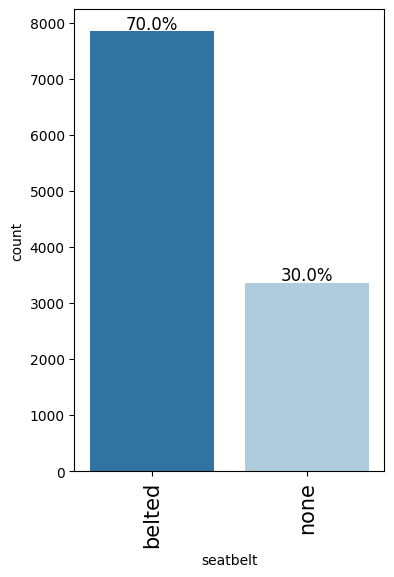

In [263]:
labeled_barplot(data, "seatbelt", perc=True)  ##Complete the code to get the labeled_barplot for seatbelt

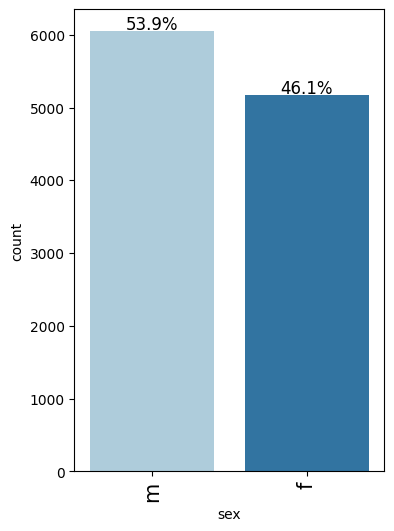

In [264]:
labeled_barplot(data, "sex", perc=True)  ##Complete the code to get the labeled_barplot for sex

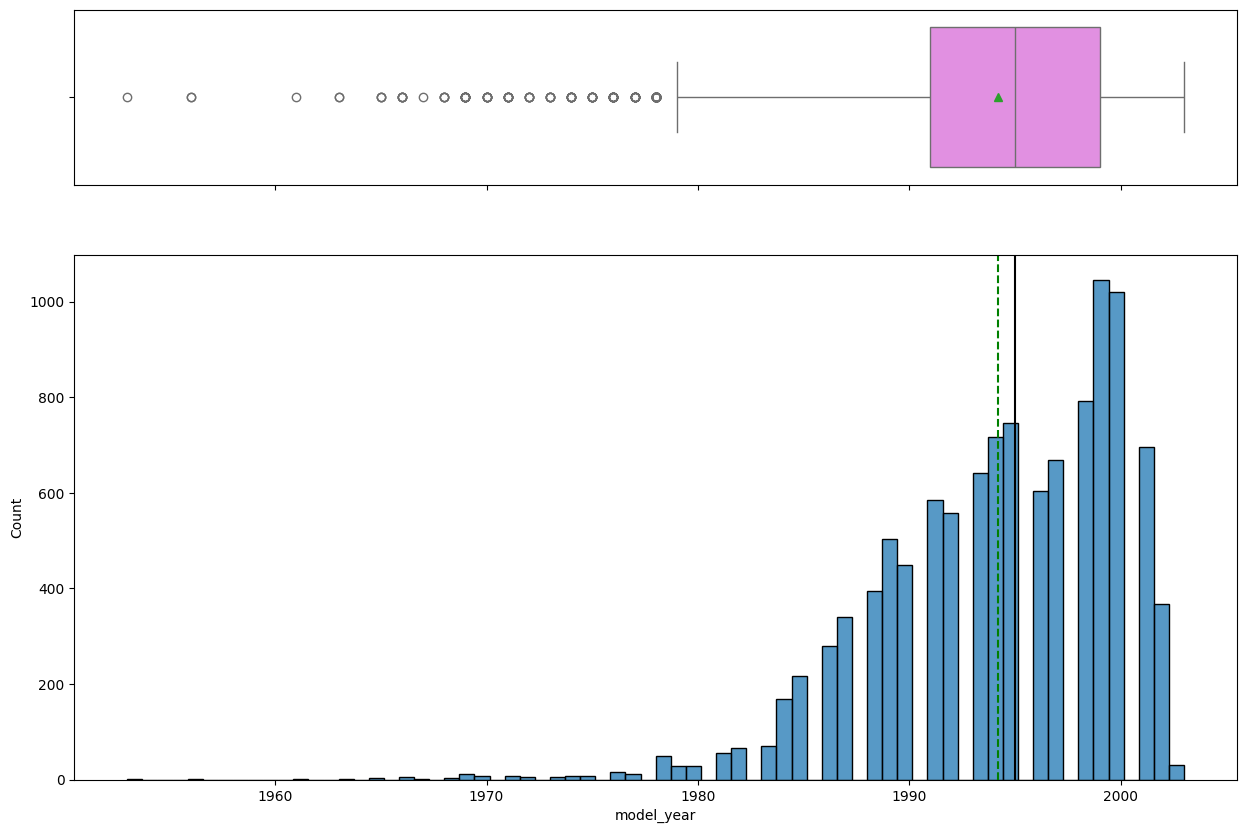

In [265]:
histogram_boxplot(data, "model_year")  ##Complete the code to get the histogram_boxplot for model_year

## Bivariate Analysis

deceased     no   yes    All
sex                         
All       10037  1180  11217
m          5332   716   6048
f          4705   464   5169
------------------------------------------------------------------------------------------------------------------------


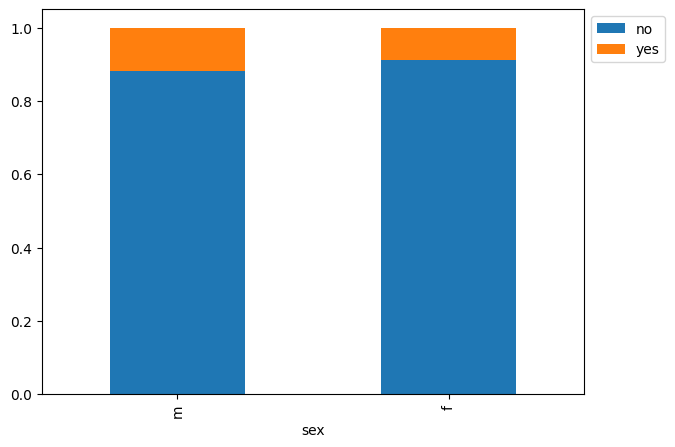

In [266]:
stacked_barplot(data, "sex", "deceased")  ## Complete the code to get stacked_barplot for sex and deceased

deceased     no   yes    All
airbag                      
All       10037  1180  11217
unavail    3484   669   4153
deploy     3997   368   4365
nodeploy   2556   143   2699
------------------------------------------------------------------------------------------------------------------------


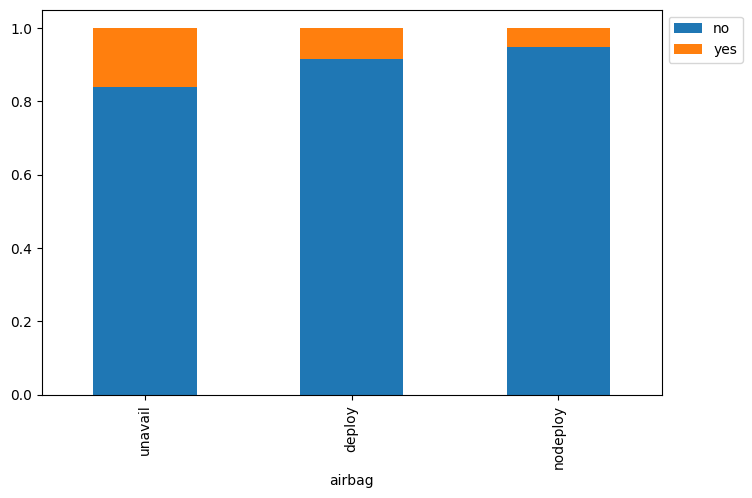

In [267]:
stacked_barplot(data, "airbag", "deceased")  ## Complete the code to get stacked_barplot for airbag and deceased

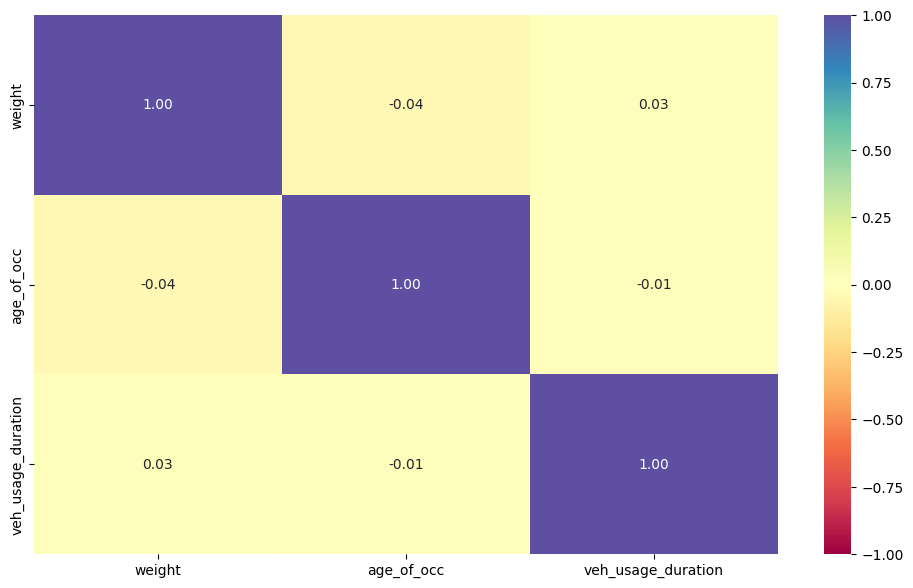

In [268]:
cols_list = ["weight", "age_of_occ", "veh_usage_duration"]

plt.figure(figsize=(12, 7))
sns.heatmap(
    data[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

# **Data Preprocessing**

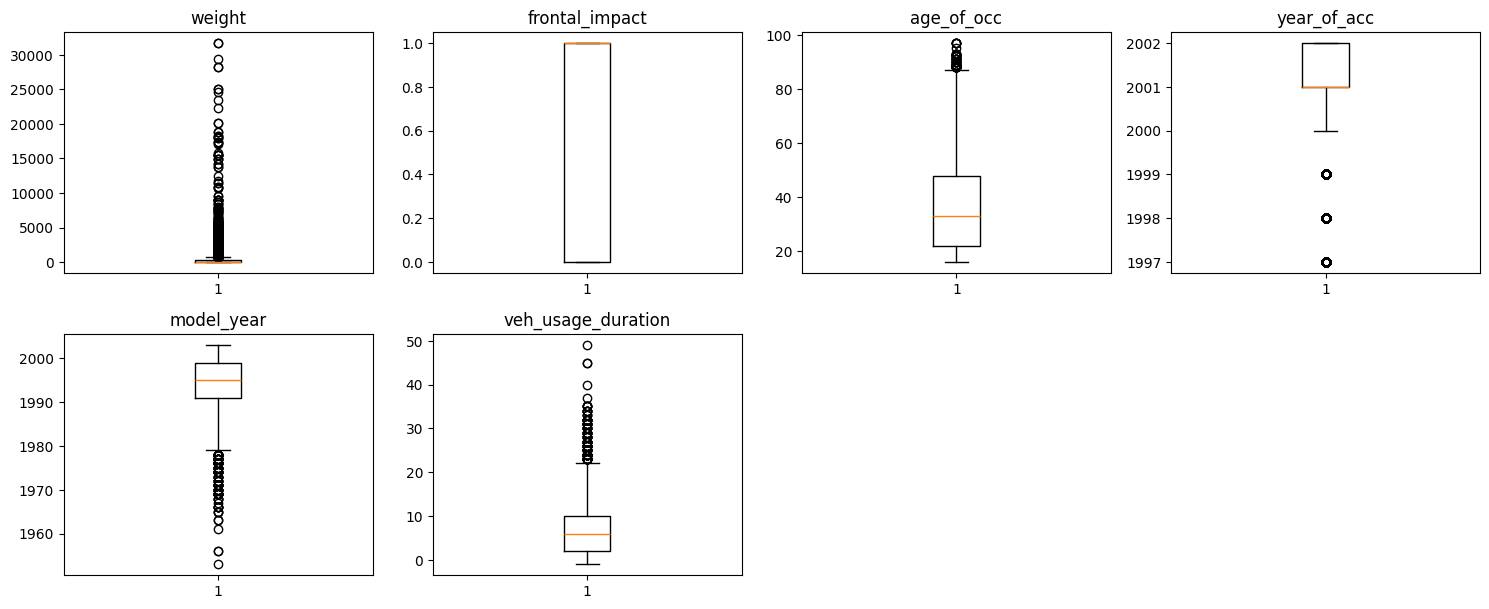

In [269]:
# outlier detection using boxplot
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(data[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

### Data Preparation for modeling

**Let's drop the unnecessary columns first before we proceed forward**.

In [270]:
data.drop(['caseid', "year_of_acc", "model_year"], axis = 1, inplace = True)  ## Complete the code to drop the unnecessary columns (caseid, year_of_acc, and model_year)

In [271]:
data.head()

,speed_range,weight,seatbelt,frontal_impact,sex,age_of_occ,airbag,occ_role,deceased,veh_usage_duration
0,55+ km/h,27.07800,none,1,m,32,unavail,driver,yes,10
1,25-39 km/h,89.62700,belted,0,f,54,nodeploy,driver,yes,3
2,55+ km/h,27.07800,belted,1,m,67,unavail,driver,yes,5
3,55+ km/h,27.07800,belted,1,f,64,unavail,pass,yes,5
4,55+ km/h,13.37400,none,1,m,23,unavail,driver,yes,11


In [272]:
data["deceased"].replace({"no":0, "yes":1},inplace=True)

In [273]:
X = data.drop(["deceased"], axis=1)
Y = data["deceased"]

X = pd.get_dummies(X, drop_first=True)

X = X.astype(float)

# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

In [274]:
y_train.reset_index(inplace = True, drop = True)

In [275]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Shape of Training set : ", y_train.shape)
print("Shape of test set : ", y_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (7851, 13)
Shape of test set :  (3366, 13)
Shape of Training set :  (7851,)
Shape of test set :  (3366,)
Percentage of classes in training set:
deceased
0   0.89530
1   0.10470
Name: proportion, dtype: float64
Percentage of classes in test set:
deceased
0   0.89364
1   0.10636
Name: proportion, dtype: float64


### Scaling the Data

In [276]:
sc = StandardScaler()

X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

# **Model Building**

First, let's create functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.
* The model_performance_classification_sklearn function will be used to check the model performance of models.
* The confusion_matrix_sklearn function will be used to plot the confusion matrix.

In [277]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification(model, predictors, target, threshold = 0.5):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    prob_pred = model.predict(predictors)
    class_pred = [1 if i >= threshold else 0 for i in prob_pred]

    acc = accuracy_score(target, class_pred)  # to compute Accuracy
    recall = recall_score(target, class_pred)  # to compute Recall
    precision = precision_score(target, class_pred)  # to compute Precision
    f1 = f1_score(target, class_pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [278]:
def plot_confusion_matrix(model, predictors, target, threshold = 0.5):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    prob_pred = model.predict(predictors)
    class_pred = [1 if i >= threshold else 0 for i in prob_pred]
    cm = confusion_matrix(target, class_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## Logistic Regression (with Statsmodel)

In [279]:
# Adding constant to data for Logistic Regression
X_train_with_intercept = SM.add_constant(X_train_scaled)
X_test_with_intercept = SM.add_constant(X_test_scaled)

In [280]:
X_train_with_intercept.head()

,const,weight,frontal_impact,age_of_occ,veh_usage_duration,speed_range_10-24 km/h,speed_range_25-39 km/h,speed_range_40-54 km/h,speed_range_55+ km/h,seatbelt_none,sex_m,airbag_nodeploy,airbag_unavail,occ_role_pass
0,1.00000,-0.15444,-1.34236,-0.84838,1.11010,-0.97348,1.54925,-0.36813,-0.28453,-0.65420,0.91931,-0.56740,1.31055,-0.52927
1,1.00000,0.47399,-1.34236,-1.12278,0.56322,1.02725,-0.64547,-0.36813,-0.28453,-0.65420,0.91931,-0.56740,1.31055,-0.52927
2,1.00000,-0.30476,0.74496,-1.12278,-0.89511,-0.97348,1.54925,-0.36813,-0.28453,-0.65420,0.91931,-0.56740,-0.76304,-0.52927
3,1.00000,0.27321,0.74496,-1.17766,0.56322,1.02725,-0.64547,-0.36813,-0.28453,-0.65420,0.91931,-0.56740,-0.76304,-0.52927
4,1.00000,0.19543,0.74496,-0.13494,2.02155,-0.97348,1.54925,-0.36813,-0.28453,1.52859,-1.08778,-0.56740,1.31055,-0.52927


In [281]:
# Replace statsmodels with scikit-learn Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [282]:
y_pred = model.predict(X_train_scaled)
y_pred[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [283]:
logistic_reg_perf_train = model_performance_classification(
    model, X_train_with_intercept.drop(columns=["const"]), y_train
)
logistic_reg_perf_train

,Accuracy,Recall,Precision,F1
0,0.85136,0.66545,0.38013,0.48386


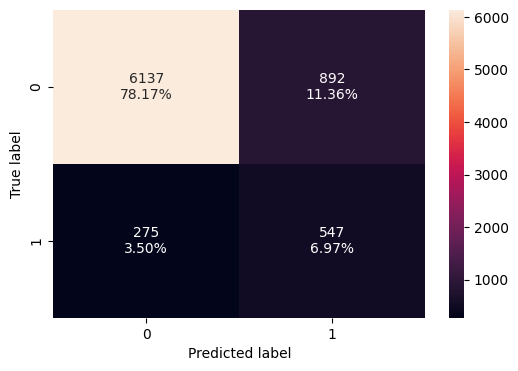

In [284]:
plot_confusion_matrix(model, X_train_with_intercept.drop(columns=["const"]), y_train)

### Checking Logistic Regression model performance on test set

In [285]:
logistic_reg_perf_test = model_performance_classification(
    model, X_test_with_intercept.drop(columns=["const"]), y_test
)
logistic_reg_perf_test

,Accuracy,Recall,Precision,F1
0,0.86334,0.67877,0.41327,0.51374


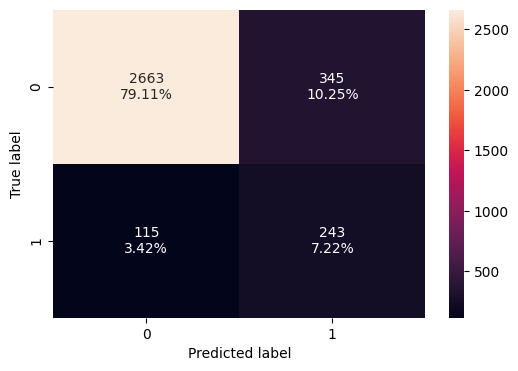

In [286]:
plot_confusion_matrix(model, X_test_with_intercept.drop(columns=["const"]), y_test)

## KNN Classifier (K = 3)

In [287]:
#Build KNN Model
knn_model = KNeighborsClassifier(n_neighbors = 3)  ## Complete the code to build KNN model with nummber of neighbors as 3
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [288]:
knn_perf_train = model_performance_classification(knn_model,X_train_scaled,y_train)  ## Complete the code to get the model performance on training set
knn_perf_train

,Accuracy,Recall,Precision,F1
0,0.93810,0.59124,0.76415,0.66667


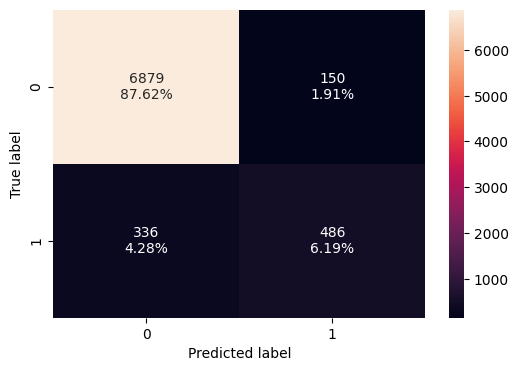

In [289]:
plot_confusion_matrix(knn_model,X_train_scaled,y_train)  ## Complete the code to plot the confusion matrix for training set

### Checking KNN Classifier performance on test set

In [290]:
knn_perf_test = model_performance_classification(knn_model,X_test_scaled,y_test)  ## Complete the code to get the model performance on test set
knn_perf_test

,Accuracy,Recall,Precision,F1
0,0.88919,0.33799,0.47082,0.39350


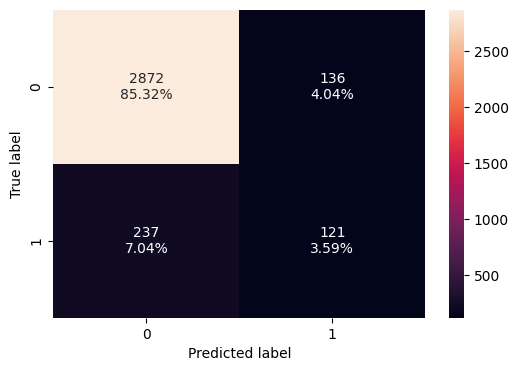

In [291]:
plot_confusion_matrix(knn_model,X_test_scaled,y_test)  ## Complete the code to plot the confusion matrix for test set

## Decision Tree Classifier

In [292]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [293]:
decision_tree_perf_train = model_performance_classification(dt_model,X_train,y_train)  ## Complete the code to get the model performance on training set
decision_tree_perf_train

,Accuracy,Recall,Precision,F1
0,1.00000,1.00000,1.00000,1.00000


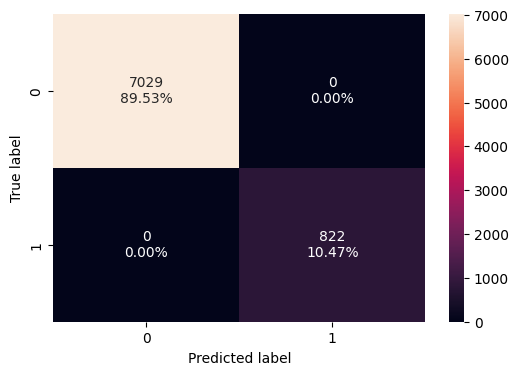

In [294]:
plot_confusion_matrix(dt_model,X_train,y_train)  ## Complete the code to plot the confusion matrix for training set

### Checking Decision Tree Classifier performance on test set

In [295]:
decision_tree_perf_test = model_performance_classification(dt_model,X_test_scaled,y_test)  ## Complete the code to get the model performance on test set
decision_tree_perf_test

,Accuracy,Recall,Precision,F1
0,0.78075,0.42458,0.22222,0.29175


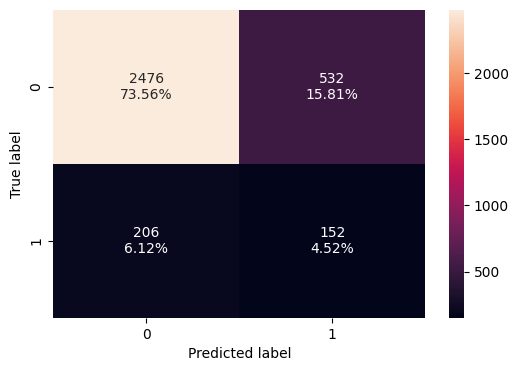

In [296]:
plot_confusion_matrix(dt_model,X_test_scaled,y_test)  ## Complete the code to plot the confusion matrix for test set

# **Model Performance Improvement**

In [297]:
# Replace statsmodels with scikit-learn Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [298]:
# Define the selected features
selected_features = ['weight', 'frontal_impact', 'age_of_occ', 'veh_usage_duration', 
					 'speed_range_10-24 km/h', 'speed_range_25-39 km/h', 
					 'speed_range_40-54 km/h', 'speed_range_55+ km/h', 
					 'seatbelt_none', 'sex_m', 'airbag_nodeploy', 
					 'airbag_unavail', 'occ_role_pass']

X_train_significant = X_train_with_intercept[selected_features]
X_test_significant = X_test_with_intercept[selected_features]  ## Complete the code to get the test set with significant features
X_train_significant.head(10)

,weight,frontal_impact,age_of_occ,veh_usage_duration,speed_range_10-24 km/h,speed_range_25-39 km/h,speed_range_40-54 km/h,speed_range_55+ km/h,seatbelt_none,sex_m,airbag_nodeploy,airbag_unavail,occ_role_pass
0,-0.15444,-1.34236,-0.84838,1.11010,-0.97348,1.54925,-0.36813,-0.28453,-0.65420,0.91931,-0.56740,1.31055,-0.52927
1,0.47399,-1.34236,-1.12278,0.56322,1.02725,-0.64547,-0.36813,-0.28453,-0.65420,0.91931,-0.56740,1.31055,-0.52927
2,-0.30476,0.74496,-1.12278,-0.89511,-0.97348,1.54925,-0.36813,-0.28453,-0.65420,0.91931,-0.56740,-0.76304,-0.52927
3,0.27321,0.74496,-1.17766,0.56322,1.02725,-0.64547,-0.36813,-0.28453,-0.65420,0.91931,-0.56740,-0.76304,-0.52927
4,0.19543,0.74496,-0.13494,2.02155,-0.97348,1.54925,-0.36813,-0.28453,1.52859,-1.08778,-0.56740,1.31055,-0.52927
5,-0.12072,0.74496,-0.57398,-1.07740,-0.97348,1.54925,-0.36813,-0.28453,-0.65420,-1.08778,-0.56740,-0.76304,-0.52927
6,-0.29066,0.74496,2.99320,-0.34824,-0.97348,1.54925,-0.36813,-0.28453,-0.65420,0.91931,-0.56740,-0.76304,-0.52927
7,2.13117,0.74496,-0.62886,-1.07740,1.02725,-0.64547,-0.36813,-0.28453,-0.65420,0.91931,1.76243,-0.76304,-0.52927
8,-0.27989,0.74496,-0.40934,0.19864,-0.97348,-0.64547,-0.36813,3.51455,-0.65420,0.91931,-0.56740,1.31055,-0.52927
9,-0.17273,-1.34236,-0.73862,-0.71282,-0.97348,-0.64547,2.71641,-0.28453,-0.65420,-1.08778,-0.56740,-0.76304,-0.52927


In [299]:
# Replace statsmodels with scikit-learn Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

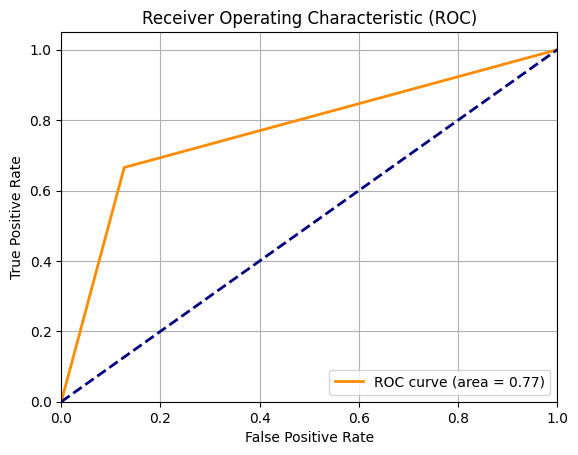

In [300]:
y_pred = model.predict(X_train_significant)
fpr, tpr, thresholds = roc_curve(y_train, y_pred)

# Plot ROC curve
roc_auc = roc_auc_score(y_train, y_pred)  ## Complete the code to get the ROC-AUC score
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [301]:
# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_logit = round(thresholds[optimal_idx], 3)
print("\nOptimal Threshold: ", optimal_threshold_logit)


Optimal Threshold:  1.0


In [302]:
# Define and train LogisticReg_2
LogisticReg_2 = LogisticRegression(max_iter=1000)
LogisticReg_2.fit(X_train_significant, y_train)

# Calculate the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_logit = round(thresholds[optimal_idx], 3)
print("\nOptimal Threshold: ", optimal_threshold_logit)

# Evaluate the model
logistic_reg_new_perf_train = model_performance_classification(
    LogisticReg_2, X_train_significant, y_train, optimal_threshold_logit
)
logistic_reg_new_perf_train


Optimal Threshold:  1.0


,Accuracy,Recall,Precision,F1
0,0.91084,0.34550,0.63677,0.44795


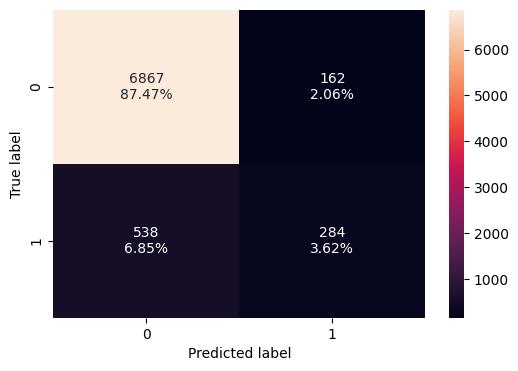

In [303]:
plot_confusion_matrix(LogisticReg_2, X_train_significant, y_train, optimal_threshold_logit)

In [304]:
logistic_reg_new_perf_test = model_performance_classification(
    LogisticReg_2, X_test_significant, y_test, optimal_threshold_logit
)

logistic_reg_new_perf_test

,Accuracy,Recall,Precision,F1
0,0.91444,0.36592,0.68229,0.47636


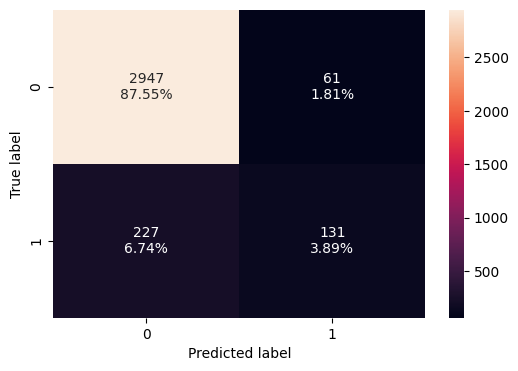

In [305]:
plot_confusion_matrix(LogisticReg_2, X_test_significant, y_test, optimal_threshold_logit)

In [306]:
knn_tuned = KNeighborsClassifier(n_neighbors = 3)  ## Complete the code to build KNN model with nummber of neighbors as best_k
knn_tuned.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [307]:
knn_tuned_perf_train = model_performance_classification(knn_tuned,X_train,y_train)  ## Complete the code to get model performance on training data
knn_tuned_perf_train

,Accuracy,Recall,Precision,F1
0,0.89530,0.00000,0.00000,0.00000


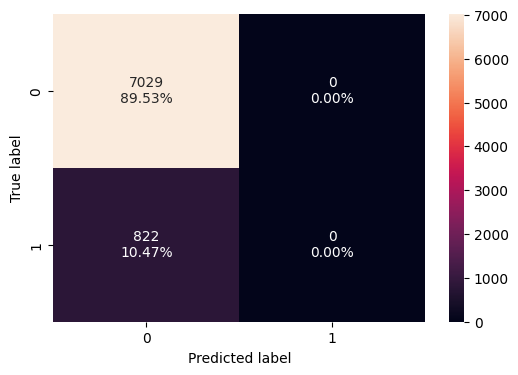

In [308]:
plot_confusion_matrix(knn_tuned,X_train,y_train)  ## Complete the code to create confusion matrix for training data

In [309]:
knn_tuned_perf_test = model_performance_classification(knn_tuned,X_test_scaled,y_test)  ## Complete the code to get model performance on test data
knn_tuned_perf_test

,Accuracy,Recall,Precision,F1
0,0.88919,0.33799,0.47082,0.39350


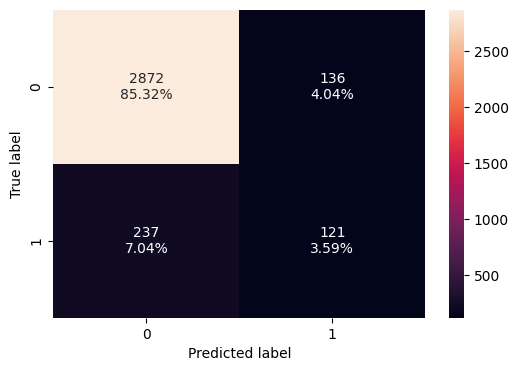

In [310]:
plot_confusion_matrix(knn_tuned,X_test_scaled,y_test)  ## Complete the code to create confusion matrix for test data

In [311]:
# Choose the type of classifier.
dt_model_tuned = DecisionTreeClassifier(random_state=42)

# Grid of parameters to choose from
parameters = {
    "max_depth": np.arange(5, 13, 2),                          ## Max Depth of the decision tree
    "max_leaf_nodes": [10, 20, 40, 50, 75, 100],               ## Maximum number of leaf nodes
    "min_samples_split": [2, 5, 7, 10, 20, 30],                ## Minimum number of samples required to split an internal node
    "class_weight": ['balanced', None]                         ## whether or not to used balanced weights for impurity computations
}

# Run the grid search
grid_obj = GridSearchCV(dt_model_tuned, parameters, scoring='recall', cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dt_model_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
dt_model_tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, max_leaf_nodes=10,
                       random_state=42)

In [312]:
decision_tree_tuned_perf_train = model_performance_classification(dt_model_tuned,X_train,y_train)  ## Complete the code to get model performance on training data
decision_tree_tuned_perf_train

,Accuracy,Recall,Precision,F1
0,0.77608,0.86983,0.30220,0.44856


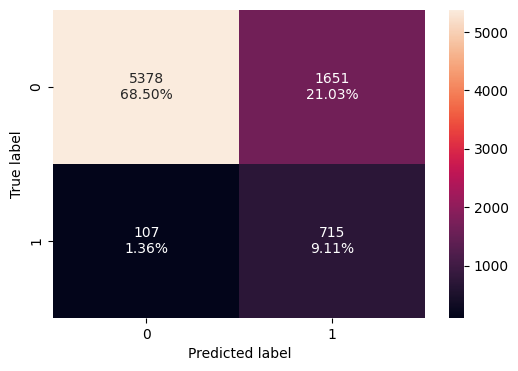

In [313]:
plot_confusion_matrix(dt_model_tuned,X_train,y_train)  ## Complete the code to create confusion matrix for training data

In [314]:
decision_tree_tuned_perf_test = model_performance_classification(dt_model_tuned,X_test_scaled,y_test)  ## Complete the code to get model performance on test data
decision_tree_tuned_perf_test

,Accuracy,Recall,Precision,F1
0,0.65270,0.87989,0.21860,0.35019


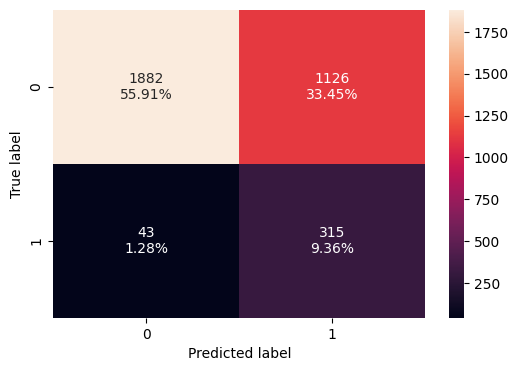

In [315]:
plot_confusion_matrix(dt_model_tuned,X_test_scaled,y_test)  ## Complete the code to create confusion matrix for test data

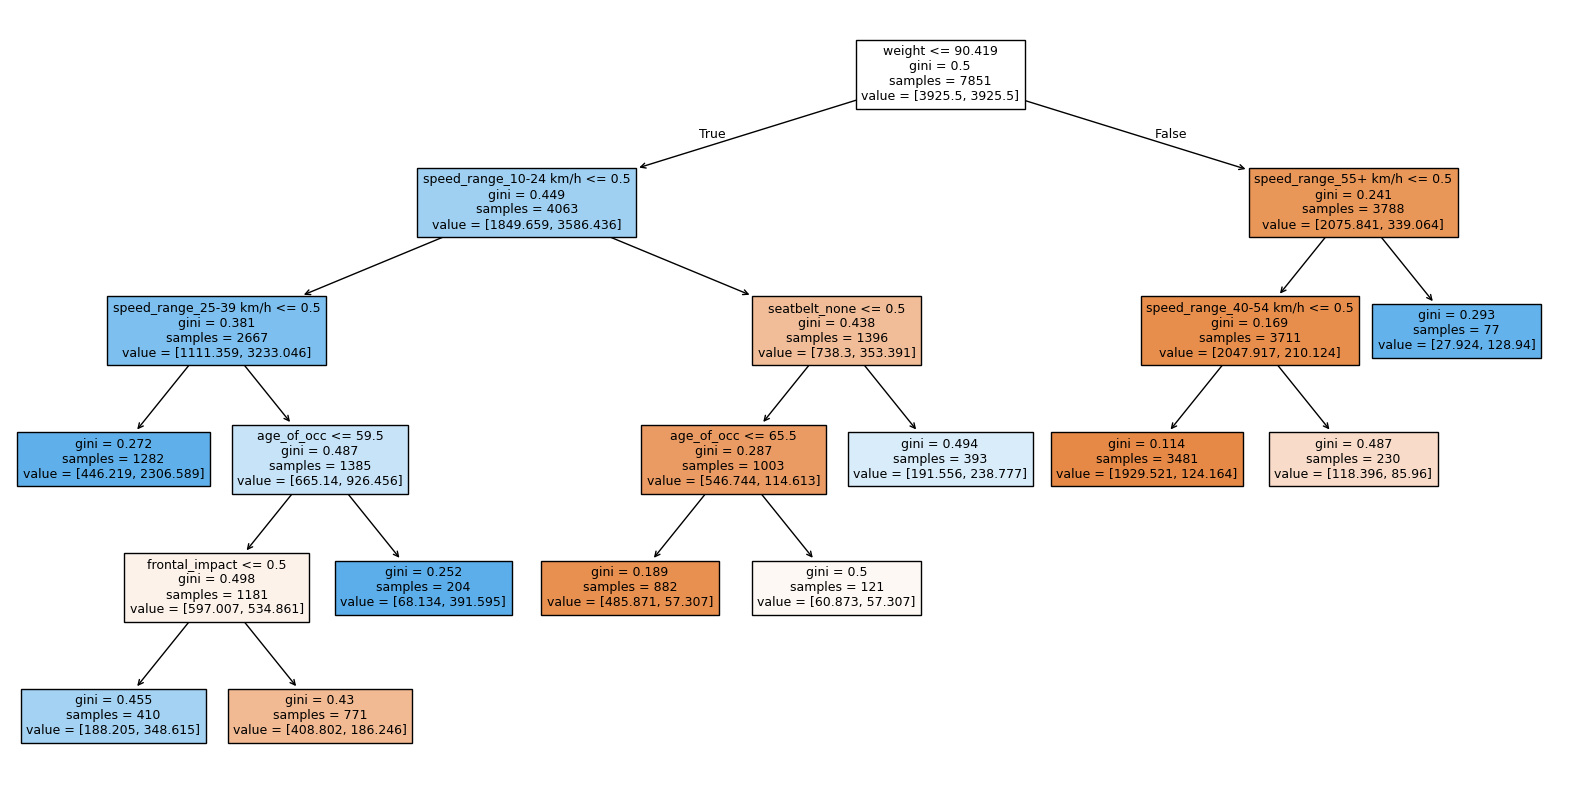

In [316]:
plt.figure(figsize=(20, 10))
out = tree.plot_tree(
    dt_model_tuned,
    feature_names=X_train.columns.tolist(),
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
# below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

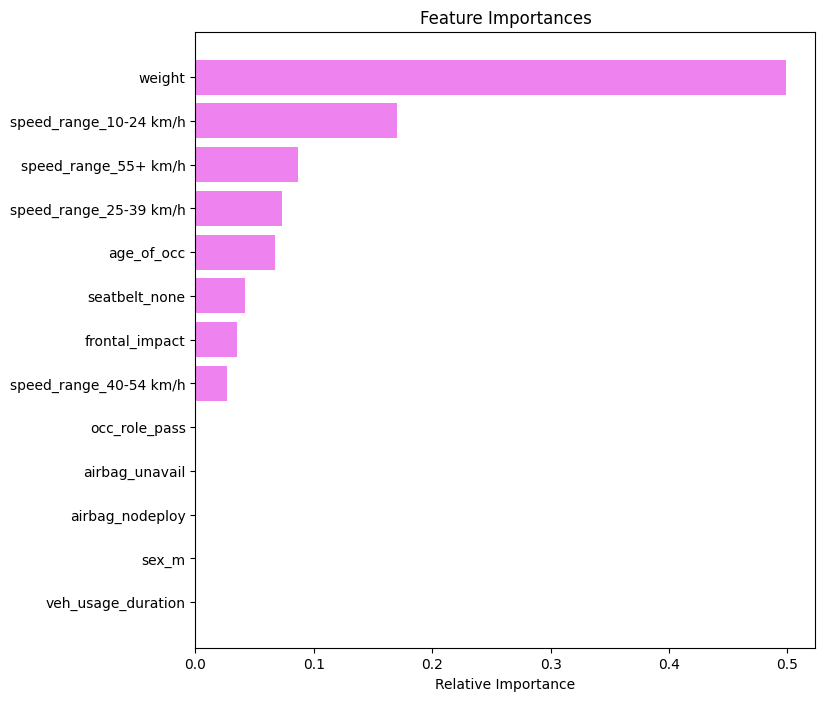

In [317]:
# Uncomment and run to check feature importance for Tuned Decision Tree model


 # importance of features in the tree building

feature_names = X_train.columns.tolist()
importances = dt_model_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

# **Model Performance Comparison and Final Model Selection**

In [318]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        logistic_reg_perf_train.T,
        logistic_reg_new_perf_train.T,
        knn_perf_train.T,
        knn_tuned_perf_train.T,
        decision_tree_perf_train.T,
        decision_tree_tuned_perf_train.T
            ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression Base",
    "Logistic Regression (Optimal threshold)",
    "KNN Base",
    "KNN Tuned",
    "Decision Tree Base",
    "Decision Tree Tuned"
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression Base,Logistic Regression (Optimal threshold),KNN Base,KNN Tuned,Decision Tree Base,Decision Tree Tuned
Accuracy,0.85136,0.91084,0.93810,0.89530,1.00000,0.77608
Recall,0.66545,0.34550,0.59124,0.00000,1.00000,0.86983
Precision,0.38013,0.63677,0.76415,0.00000,1.00000,0.30220
F1,0.48386,0.44795,0.66667,0.00000,1.00000,0.44856


In [319]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [
        logistic_reg_perf_test.T,
        logistic_reg_new_perf_test.T,
        knn_perf_test.T,
        knn_tuned_perf_test.T,
        decision_tree_perf_test.T,
        decision_tree_tuned_perf_test.T
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Logistic Regression Base",
    "Logistic Regression (Optimal threshold)",
    "KNN Base",
    "KNN Tuned",
    "Decision Tree Base",
    "Decision Tree Tuned"
]
print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


,Logistic Regression Base,Logistic Regression (Optimal threshold),KNN Base,KNN Tuned,Decision Tree Base,Decision Tree Tuned
Accuracy,0.86334,0.91444,0.88919,0.88919,0.78075,0.65270
Recall,0.67877,0.36592,0.33799,0.33799,0.42458,0.87989
Precision,0.41327,0.68229,0.47082,0.47082,0.22222,0.21860
F1,0.51374,0.47636,0.39350,0.39350,0.29175,0.35019


In [320]:
import joblib
joblib.dump(LogisticReg_2, "model.pkl")
joblib.dump(sc, "scaler.pkl")

['scaler.pkl']

In [321]:
# Save model and columns for Streamlit
import joblib
joblib.dump(model, "model.pkl")
joblib.dump(X_train.columns.tolist(), "model_columns.pkl")

# Show probability
prob = model.predict_proba(input_df)[:, 1][0]
print(f"Predicted probability of death: {prob:.2f}")
print("Predicted: Deceased" if prob > 0.5 else "Predicted: Not Deceased")

NameError: name 'input_df' is not defined